<h1>Loop Runner - Single Xi</h1>

<b>Description:</b> Here, I'm evolving loops for the given simulation. I'm employing a new technique here of utilizing two different binned density matrices, one which is high resolution and localized on the halo, and a low resolution one which covers the rest of the box. I'm also shifting the coordinates so the halo is always in the center.

In [1]:
# Import Statements
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
import scipy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import os
import time

In [2]:
# Global Rocket Parameters
xi = 50
Gmu = 1e-12
GammaFrac = 0.1
vf = 0.3

# Global Simulation Parameters
tmax = 100
zi = 127
h = 0.7
rhoScale = 4.78e-20 # Mpc / Msun

Lbox = 100
LLowRes, LHighRes = [100, 1]
dxLowRes, dxHighRes = [1, 0.01]
binsLowRes, binsHighRes = [int(LLowRes / dxLowRes) + 1, int(LHighRes / dxHighRes)]

# Global Physical Parameters
t0 = 4213 / h # Mpc / h
H0 = 0.0003333

# No. of Rockets
densRocket = 1e-6 * ((Gmu * xi) ** (-3/2)) * (t0 ** -3) * ((1 + zi) ** 3)
nRockets = int(densRocket * ((LHighRes / 2) ** 3))

In [3]:
# Set the Environment
envi = 1
envs = ["Cluster", "Local"]
env = envs[envi]

if env == "Cluster":
    # Cluster dirs
    neilDir = "/cluster/tufts/hertzberglab/nshah14/"
    homeDir = "/cluster/tufts/hertzberglab/shared/Rockets/"
    simName = "Sim_100v"
    simDir = homeDir + simName + "/"
    Div = "/"
elif env == "Local":
    # Cluster dirs
    homeDir = "C:\\Users\\Neil\\Documents\\PhD\\Rocket Force\\"
    simName = "Sim_100v"
    simDir = homeDir + simName + "\\"
    Div = "\\"

print("Working in the {} environment".format(env))

Working in the Local environment


Utility Functions

In [4]:
# make more realistic, add in influence of overdensity
def getHubbleEvol():
    OMatter = 0.25
    OLambda = 0.75

    da_dt = lambda a, t: a * H0 * np.sqrt(OMatter / a**3 + OLambda)

    a0 = 1 / (1 + zi)
    tInt = np.linspace(0, 1.1 / H0, 1000)
    af = interpolate.InterpolatedUnivariateSpline(tInt, integrate.odeint(da_dt, y0=a0, t=tInt)[:, 0])
    aDotf = af.derivative(n=1)
    tEnd = sp.optimize.fsolve(lambda t: af(t) - 1.0, x0=(1.0 / H0))[0]

    tArr = np.asarray([(tEnd + t)**(t / tmax) - 1 for t in range(tmax)])
    aArr = np.asarray([af(t) for t in tArr])
    HArr = np.asarray([aDotf(t) / af(t) for t in tArr])

    return tArr, aArr, HArr

In [5]:
def getCoords(t):
    snapDir = simDir + "snapdir_{:03d}{}".format(t, Div)
    pathArr = np.asarray(os.listdir(snapDir))
    
    ptypeN = 3
    coordsArr = [np.empty((0, 3), dtype=float) for i in range(ptypeN)]

    for pi in range(ptypeN):
        ptype = pi + 1
        for pathi in np.arange(0, pathArr.size):
            datGet = "/PartType{:d}/Coordinates".format(ptype)
            try:
                coords = np.asarray(h5py.File(snapDir + pathArr[pathi], 'r')[datGet])
                coordsArr[pi] = np.concatenate([coordsArr[pi], coords], axis=0)
            except KeyError:
                # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
                pass
    
    return(coordsArr)

def getHaloCoords(t):
    haloPtype = 1

    groupDir = simDir + "groups_{:03d}{}".format(t, Div)
    snapDir = simDir + "snapdir_{:03d}{}".format(t, Div)
    groupPaths = np.asarray(os.listdir(groupDir))
    snapPaths = np.asarray(os.listdir(snapDir))

    coordsArr = getCoords(t)[haloPtype - 1]
    
    haloCoords = np.empty((0, 0))
    for i, pathi in enumerate(groupPaths):
        gfile = h5py.File(groupDir + pathi, 'r')
        try:
            haloInit = int(np.asarray(gfile["/Group/GroupOffsetType/"])[0, haloPtype - 1])
            haloN = int(np.asarray(gfile["/Group/GroupLen/"])[haloPtype - 1])
            haloCoords = coordsArr[haloInit:(haloInit + haloN + 1), :]
            break
        except KeyError:
            pass
    
    return(haloCoords)

def getHaloStartTime():
    pathSave = simDir + "HaloStartTime.npy"

    if os.path.exists(pathSave):
        tStart = np.load(pathSave)[0]
    else:
        tStart = 0
        go = True
        for t in range(tmax):
            groupDir = simDir + "groups_{:03d}{}".format(t, Div)
            snapDir = simDir + "snapdir_{:03d}{}".format(t, Div)
            groupPaths = np.asarray(os.listdir(groupDir))
            snapPaths = np.asarray(os.listdir(snapDir))
            
            for i, pathi in enumerate(groupPaths):
                gfile = h5py.File(groupDir + pathi, 'r')
                try:
                    catch = gfile["/Group/GroupOffsetType/"]
                    tStart = t
                    go = False
                    break
                except KeyError:
                    continue
            if not go:
                break
        np.save(pathSave, np.asarray([tStart]))
    
    return(tStart)

def getHaloC(t):
    haloCoords = getHaloCoords(t)
    if haloCoords.shape[0] == 0:
        t0 = getHaloStartTime()
        halo0 = getHaloCoords(t0)
        xc = np.asarray([np.mean(halo0[:, i]) for i in range(3)])
    else:
        xc = np.asarray([np.mean(haloCoords[:, i]) for i in range(3)])
    return(xc)

In [6]:
def getMass(t):
    massArr = [np.empty((0, 1), dtype=float) for i in range(ptypeN)]

    snapDir = simDir + "snapdir_{:03d}/".format(t)
    snapPaths = np.asarray(os.listdir(snapDir))
    path1 = snapDir + "snapshot_{:03d}.0.hdf5".format(t)

    ptypeN = 3
    for pi in range(ptypeN):
        ptype = pi + 1
        for pathi, path in enumerate(snapPaths):
            datGet = "/PartType{:d}/Masses".format(ptype)
            try:
                masses = np.asarray(h5py.File(snapDir + path, 'r')[datGet])
                massArr[pi] = np.concatenate([massArr[pi], masses], axis=0)
            except KeyError:
                # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
                pass

    return massArr

In [ ]:
masstest = getMass(0)

(0,)
[0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584 0.05559584
 0.05559584 0.01426033 0.01519851 0.01501088 0.01426033 0.0140727
 0.01463561 0.01632433 0.01463561 0.01426033 0.01463561 0.01482324
 0.01594906 0.01519851 0.01444797 0.01482324 0.01501088 0.01576142
 0.01501088 0.01576142 0.01576142 0.01501088 0.01651197 0.01519851
 0.00168872 0.00225163 0.01482324 0.01557379 0.01463561 0.01632433
 0.01519851 0.00187636 0.00187636 0.01482324 0.01538615 0.01557379
 0.00168872 0.00168872 0.00168872 0.002064   0.00168872 0.

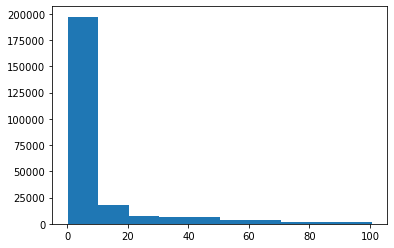

In [53]:
tFix = 50
massTab = np.zeros(3)

snapDir = simDir + "snapdir_{:03d}/".format(tFix)
path1 = snapDir + "snapshot_{:03d}.0.hdf5".format(tFix)
fil = h5py.File(path1, 'r')

fig = plt.figure()
ptypeN = 3
for pi in np.arange(0, ptypeN):
    ptype = pi + 1
    datGet = "/PartType{:d}/Masses".format(ptype)
    masses = np.asarray(fil[datGet])
    if pi == 1:
        print(masses[np.nonzero(masses - masses[0])[0]])
    print(np.nonzero(np.round(masses - masses[0], 2))[0].shape)
    if pi == 2:
        print(masses[0])
        plt.hist(masses)

In [6]:
def getRhoxHC(t, override=False):
    dirSave = simDir + "rhox_HaloCentered{}rhox_HC__LLR_{:03d}_{:03d}__bLR_{:04d}__LHR_{:03d}_{:03d}__bHR_{:04d}{}".format(
        Div, int(np.floor(LLowRes)), int(1e3 * np.mod(LLowRes, 1)), binsLowRes, int(np.floor(LHighRes)), int(1e3 * np.mod(LHighRes, 1)), binsHighRes, Div)
    if not os.path.exists(dirSave):
        os.makedirs(dirSave)
    pathSave = dirSave + "rhox_HC__LLR_{:03d}_{:03d}__bLR_{:04d}__LHR_{:03d}_{:03d}__bHR_{:04d}__t_{:03d}.npz".format(
        int(np.floor(LLowRes)), int(1e3 * np.mod(LLowRes, 1)), binsLowRes, int(np.floor(LHighRes)), int(1e3 * np.mod(LHighRes, 1)), binsHighRes, t)
    
    if os.path.exists(pathSave) and not override:
        rhoxLoad = np.load(pathSave)
        rhoxLowRes, rhoxHighRes, rhoxTotal = [rhoxLoad[rhoStr] for rhoStr in rhoxLoad.files]
        return [rhoxLowRes, rhoxHighRes, rhoxTotal]
    
    xC = getHaloC(t)
    ptypeN = 3
    massArr = getMass()

    rhoxLowRes = np.zeros((binsLowRes, binsLowRes, binsLowRes))
    rhoxHighRes = np.zeros((binsHighRes, binsHighRes, binsHighRes))
    coords = getCoords(t)
    for pi in np.arange(0, ptypeN):
        ptype = pi + 1
        mi = massArr[pi]

        for ci, coord in enumerate(coords[pi]):
            try:
                if False in (np.abs(coord - xC) < LLowRes/2):
                    continue
                elif False in (np.abs(coord - xC) < LHighRes/2):
                    iLR, jLR, kLR = [int(np.floor((coord[i] - (xC[i] - LLowRes/2) + dxLowRes) / dxLowRes)) for i in range(3)]
                    rhoxLowRes[iLR, jLR, kLR] += mi / (dxLowRes ** 3)
                else:
                    iHR, jHR, kHR = [int(np.floor((coord[i] - (xC[i] - LHighRes/2)) / dxHighRes)) for i in range(3)]
                    rhoxHighRes[iHR, jHR, kHR] += mi / (dxHighRes ** 3)
            except IndexError:
                pass

    rhoxTotal = rhoxLowRes.copy()
    rhoxHighResAvg = np.asarray([rhoxHighRes[i, j, k] for i in range(binsHighRes) for j in range(binsHighRes) for k in range(binsHighRes)]).sum() / binsHighRes**3
    rhoxTotal[int((binsLowRes - 1) / 2), int((binsLowRes - 1) / 2), int((binsLowRes - 1) / 2)] = rhoxHighResAvg
    
    rhoxLowRes *= rhoScale * 1e10
    rhoxHighRes *= rhoScale * 1e10
    rhoxTotal *= rhoScale * 1e10
    np.savez(pathSave, rhoxLowRes, rhoxHighRes, rhoxTotal)
    
    return([rhoxLowRes, rhoxHighRes, rhoxTotal])

def rhoxHCInstantiate():
    print("Instantiating Density Matrices:")

    T0 = time.time()
    for t in range(tmax):
        if np.mod(t, 10) == 0:
            print("   Processing: {:03d} / {:03d} (Time Elapsed: {}, Time Estimated Remaining: {})".format(t, tmax, toMS(time.time() - T0), toMS((tmax / (t + 1)) * (time.time() - T0))))
        catch1 = getRhoxHC(t, override=True)
    print("Finished! Took {} total".format(toMS(time.time() - T0)), end="\n\n")

In [7]:
def getkArr(L, bins, override=False):
    kArrDir = simDir + "kArrs/"
    if not os.path.exists(kArrDir):
        os.makedirs(kArrDir)
    kArrPath = kArrDir + "kArr__L_{:03d}__bins_{:03d}.npy".format(L, bins)
    if os.path.exists(kArrPath) and not override:
        kArr = np.load(kArrPath)
        return(kArr)

    kArr = np.zeros((bins, bins, bins), dtype=float)
    halfBins = int(bins / 2)
    for i in range(bins):
        for j in range(bins):
            for k in range(bins):
                lx = - (4 * bins**2 / L**2) * np.sin((np.pi / bins) * (i - halfBins))**2
                ly = - (4 * bins**2 / L**2) * np.sin((np.pi / bins) * (j - halfBins))**2
                lz = - (4 * bins**2 / L**2) * np.sin((np.pi / bins) * (k - halfBins))**2
                if i == halfBins and j == halfBins and k == halfBins:
                    kArr[i, j, k] = 1
                else:
                    kArr[i, j, k] = lx + ly + lz
    
    np.save(kArrPath, kArr)
    return kArr

def getRhokLambda(t, res):
    rhoxLowRes, rhoxHighRes, rhoxTotal = getRhoxHC(t, override=False)
    if not 'kArrLowRes' in globals():
        global kArrLowRes
        kArrLowRes = getkArr(LLowRes, binsLowRes)
    if not 'kArrHighRes' in globals():
        global kArrHighRes
        kArrHighRes = getkArr(LHighRes, binsHighRes)
    
    if res == "Low":
        kArr = kArrLowRes
        dxi = dxLowRes
        halfBins = int(binsLowRes / 2)
        rhox = rhoxLowRes

        rhokLowRes = fft.ifftn(rhoxLowRes)
        rhokL = np.divide(rhokLowRes, kArrLowRes)
    elif res == "High":
        kArr = kArrHighRes
        dxi = dxHighRes
        halfBins = int(binsHighRes / 2)
        rhox = rhoxHighRes

        rhokHighRes = fft.ifftn(rhoxHighRes)
        rhokL = np.divide(rhokHighRes, kArrHighRes)
    elif res == "Total":
        kArr = kArrLowRes
        dxi = dxLowRes
        halfBins = int(binsLowRes / 2)
        rhox = rhoxTotal

        rhokTotal = fft.ifftn(rhoxTotal)
        rhokL = np.divide(rhokTotal, kArrLowRes)
    else:
        print("ERROR! You are trying to get a kArr for a resolution which doesn't exist")
        quit()
    
    rhokL[halfBins, halfBins, halfBins] = 0
    return(rhokL)

In [8]:
def getFg(t, pos, rhokLOverride=False):
    xC = np.asarray([Lbox / 2 for i in range(3)])

    if (not 'rhokLLowRes' in globals()) or rhokLOverride:
        global rhokLLowRes
        rhokLLowRes = getRhokLambda(t, "Low")
    if (not 'rhokLHighRes' in globals()) or rhokLOverride:
        global rhokLHighRes
        rhokLHighRes = getRhokLambda(t, "High")
    if (not 'rhokLTotal' in globals()) or rhokLOverride:
        global rhokLTotal
        rhokLTotal = getRhokLambda(t, "Total")

    if False in (np.abs(pos - xC) < LLowRes/2):
        return np.zeros(3)
    elif False in (np.abs(pos - xC) < LHighRes/2):
        iTot, jTot, kTot = [int(np.floor((pos[i] - (xC[i] - LLowRes/2) + dxLowRes) / dxLowRes)) for i in range(3)]
        phixTot = fft.fftn(rhokLTotal).real
        try:
            FgTot = (4 * np.pi / (2 * dxLowRes)) * np.asarray(
                [phixTot[iTot + 1, jTot, kTot] - phixTot[iTot - 1, jTot, kTot], phixTot[iTot, jTot + 1, kTot] - phixTot[iTot, jTot - 1, kTot], phixTot[iTot, jTot, kTot + 1] - phixTot[iTot, jTot, kTot - 1]])
        except IndexError:
            FgTot = np.zeros(3)
        Fg = FgTot
    else:
        iLR, jLR, kLR = [int(np.floor((pos[i] - (xC[i] - LLowRes/2) + dxLowRes) / dxLowRes)) for i in range(3)]
        iHR, jHR, kHR = [int(np.floor((pos[i] - (xC[i] - LHighRes/2)) / dxHighRes)) for i in range(3)]
        phixLowRes = fft.fftn(rhokLLowRes).real
        phixHighRes = fft.fftn(rhokLHighRes).real

        try:
            FgLowRes = (4 * np.pi / (2 * dxLowRes)) * np.asarray(
                [phixLowRes[iLR + 1, jLR, kLR] - phixLowRes[iLR - 1, jLR, kLR], phixLowRes[iLR, jLR + 1, kLR] - phixLowRes[iLR, jLR - 1, kLR], phixLowRes[iLR, jLR, kLR + 1] - phixLowRes[iLR, jLR, kLR - 1]])
        except IndexError:
            FgLowRes = np.zeros(3)
        try:
            FgHighRes = (4 * np.pi / (2 * dxHighRes)) * np.asarray(
                [phixHighRes[iLR + 1, jLR, kLR] - phixHighRes[iLR - 1, jLR, kLR], phixHighRes[iLR, jLR + 1, kLR] - phixHighRes[iLR, jLR - 1, kLR], phixHighRes[iLR, jLR, kLR + 1] - phixHighRes[iLR, jLR, kLR - 1]])
        except IndexError:
            FgHighRes = np.zeros(3)
        Fg = FgLowRes + FgHighRes
    
    return(Fg)

In [9]:
def toMS(t):
    s = np.floor(np.mod(t, 60))
    m = np.floor(np.mod(t, 3600) / 60)
    h = np.floor(t / 3600)

    if t < 1:
        tstr = "{:f} s".format(t)
    elif t < 3600:
        tstr = "{:02d}m {:02d}s".format(int(m), int(s))
    else:
        tstr = "{}h {:02d}m {:02d}s".format(int(h), int(m), int(s))
    return tstr

In [ ]:
t0G = time.time()
print("Hello! Now Beginning Halo Centered Rocket Evolution")
print("This run has Global Parameters: xi = {}, {} Rockets, Gmu = {}, GammaFrac = {}, vf = {}".format(xi, nRockets, Gmu, GammaFrac, vf), end="\n\n")

print("Now Beginning Instantiation of rho matrices. Here I will calculate binned density matrices from the raw simulation data and save it to a file.")
rhoxHCInstantiate()

In [ ]:
print("\nNow Processing Rocket Evolution!:")

rocketSaveDir = simDir + "RocketTrajs_HC{}".format(Div)
if not os.path.exists(rocketSaveDir):
    os.makedirs(rocketSaveDir)
rocketSavePath = rocketSaveDir + "RT_HC__Run4__N_{:06d}__xi_{:03d}.npy".format(nRockets, xi)

xArr = np.zeros((nRockets, 3, tmax))
vArr = np.zeros((nRockets, 3, tmax))
FRocketArr = np.zeros((nRockets, 3))

xC = np.asarray([Lbox / 2 for i in range(3)])
xArr[:, :, 0] = np.asarray([xC + 0.5 * LHighRes * (2*np.random.rand(3)-1) for i in range(0, nRockets)])
vArr[:, :, 0] = 2.6 * (1 + zi) * np.sqrt(xi * Gmu) * vf * np.asarray([v / np.linalg.norm(v) for v in (2*np.random.rand(nRockets, 3)-1)])
FRocketArr = (H0 * GammaFrac / xi) * np.asarray([v / np.linalg.norm(v) for v in (2*np.random.rand(nRockets, 3)-1)])

tArr, aArr, HArr = getHubbleEvol()
dtArr = np.diff(tArr)
kArrLowRes = getkArr(LLowRes, binsLowRes, override=True)
kArrHighRes = getkArr(LHighRes, binsHighRes, override=True)

t0 = time.time()
for ti in np.arange(0, tmax - 1):
    t = tArr[ti]
    dti = dtArr[ti]
    ai = aArr[ti]
    Hi = HArr[ti]
    
    rhokLLowRes = getRhokLambda(ti, "Low")
    rhokLHighRes = getRhokLambda(ti, "High")
    rhokLTotal = getRhokLambda(ti, "Total")

    for ri in range(nRockets):
        FRocketi = FRocketArr[ri, :]
        Fgi = getFg(ti, xArr[ri, :, ti])
        vArr[ri, :, ti + 1] = vArr[ri, :, ti] + dti * ((Fgi + FRocketi) / ai - 2 * Hi * vArr[ri, :, ti] + 0.5 * Hi**2 * xArr[ri, :, ti])
        xArr[ri, :, ti + 1] = xArr[ri, :, ti] + dti * vArr[ri, :, ti]
    if np.mod(ti + 1, 10) == 0:
        print("   Processing t = {}/{} (Time Elapsed: {}, Estimated Time Remaining: {})".format(ti + 1, tmax, toMS(time.time() - t0), toMS((tmax / (ti + 1) - 1) * (time.time() - t0))))

print("Finished Processing Rocket Evolution! Time Taken: {}\n".format(toMS(time.time() - t0)))

np.save(rocketSavePath, np.asarray([xArr, vArr]))
print("Rocket Trajectories Successfully Exported. \nWe are now done, thank you! Total Time Taken: {}\n".format(toMS(time.time() - t0G)))

In [21]:
rhoxLowRes, rhoxHighRes, rhoxTotal = getRhoxHC(0)

(1030301,)


0.2336856561978272
0.0065184675339205606


(0.0, 100.0)

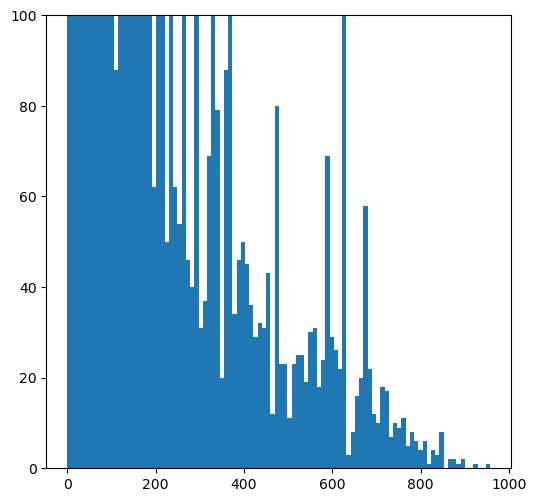

In [43]:
tArr, aArr, HArr = getHubbleEvol()
print(HArr[0])
rhoCrit = (3 / (8 * np.pi)) * (HArr[0]**2)
rhoxLowResFlat = np.asarray([rhoxLowRes[i, j, k] / (aArr[0]**3 * rhoCrit) for i in range(rhoxLowRes.shape[0]) for j in range(rhoxLowRes.shape[1]) for k in range(rhoxLowRes.shape[2])])
print(rhoCrit)

fig = plt.figure(figsize=(6, 6), dpi=100)
histPlt = plt.hist(rhoxLowResFlat, bins=100)
plt.ylim([0, 100])

In [ ]:
ptypeN = 3
coords = getCoords(0)
massArr = getMass()
massTotal = np.asarray([massArr[i] * coords[i].shape[0] for i in range(ptypeN)]).sum()

print()

In [56]:
tFix = 50
massTab = np.zeros(3)

snapDir = simDir + "snapdir_{:03d}/".format(tFix)
path1 = snapDir + "snapshot_{:03d}.0.hdf5".format(tFix)
fil = h5py.File(path1, 'r')

totMasses = np.zeros(3)
ptypeN = 3
for pi in np.arange(0, ptypeN):
    ptype = pi + 1
    datGet = "/PartType{:d}/Masses".format(ptype)
    masses = np.asarray(fil[datGet])
    totMasses[pi] = masses.sum()
    if pi == 2:
        print(masses[0] * masses.size)

totMass = totMasses.sum()
print(totMasses)
rhoTest = totMass / (100**3 * aArr[0]**3) * 1e10 * rhoScale
print(rhoTest)
print(rhoTest / rhoCrit)

15914481.157424927
[4.31825294e+01 2.11499882e+01 2.03632650e+06]
0.0020413568892396895
0.3131651540207805
